# **Projeto S**

## *Pacotes e Bibliotecas*

In [20]:
# Pacotes e Bibliotecas
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from google.oauth2 import service_account
from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

## *Código para os cursos oferecidos pelo SENAC/RN*

### Extração dos cursos oferecidos diretamente do site

In [2]:
# URL do site com a lista de cursos
url = 'https://www.rn.senac.br/todos-os-cursos'

# Requisição para acessar página
resposta_cursos = requests.get(url)
resposta_cursos.raise_for_status()  

# Verifica o HTML usando BeautifulSoup
palavras = BeautifulSoup(resposta_cursos.content, 'html.parser')
cursos = [a.text for a in palavras.select('a')]

# Transforma a lista de nomes em um DataFrame
df_cursos = pd.DataFrame(cursos, columns=['Curso']).reindex()


### Ajustando dataframe para análise

In [3]:
# Excluindo dados que não sejam os cursos
df_cursos = df_cursos.loc[df_cursos['Curso'].str.contains(' - ', na=False)].reset_index(drop=True)

In [4]:
# Separando a classe do curso e o curso propriamente dito
df_cursos[['Classe', 'Curso_senac']] = df_cursos['Curso'].str.split(' - ', n=1, expand=True)
df_cursos = df_cursos.drop(columns='Curso')

# Removendo '\r\n' e espaços em branco adicionais
df_cursos['Classe'] = df_cursos['Classe'].str.replace(r'\s*\r\n\s*', '', regex=True)
df_cursos['Curso_senac'] = df_cursos['Curso_senac'].str.replace(r'\s*\r\n\s+', '', regex=True)

## *Código para acessar banco de dados do Novo CAGED e descrições dos microdados*

### Conectando e consultando o banco de dados BigQuery e planilhas com as descrições dos microdados

In [5]:
# Consultando a chave de acesso ao banco de dados BigQuery
key_path = "D:/Projeto_S/baseprojetos.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# Configurar o cliente BigQuery
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

Consulta SQL para extração de dataframe

In [6]:
# consulta SQL ao banco de dados de movimentações do CAGED executando os filtros necessários para o projeto
query_movimentacoes = """
    SELECT 
        ano, 
        mes, 
        sigla_uf, 
        cnae_2_secao, 
        cnae_2_subclasse, 
        cbo_2002,
        tipo_movimentacao
    FROM 
        `baseprojetos.caged_rn.caged_rn`
    WHERE 
        ano = 2023
        AND sigla_uf = 'RN'
        AND tipo_movimentacao IN ('10', '20', '25', '97')
"""

# Executar a consulta e transformar os resultados em um DataFrame
df_caged_sql = client.query(query_movimentacoes).to_dataframe()

# Exibir o DataFrame
df_caged_sql

,ano,mes,sigla_uf,cnae_2_secao,cnae_2_subclasse,cbo_2002,tipo_movimentacao
0,2023,8,RN,B,810002,784205,97
1,2023,8,RN,B,810002,784205,97
2,2023,8,RN,C,1412601,763215,97
3,2023,8,RN,C,1412601,141205,97
4,2023,8,RN,C,1412601,763210,97
...,...,...,...,...,...,...,...
209146,2023,7,RN,S,9609299,514320,97
209147,2023,7,RN,T,9700500,391115,97
209148,2023,7,RN,T,9700500,391115,97
209149,2023,7,RN,T,9700500,391115,97


In [7]:
# Dataframes a partir do excel
cnae_secao = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Estabelecimento.xlsx', sheet_name='seção')
cnae_subclasse = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Estabelecimento.xlsx', sheet_name='subclasse')
cbo_2002 = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Movimentação.xlsx', sheet_name='cbo2002ocupação')
tipo_movimentacao = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Movimentação.xlsx', sheet_name='tipomovimentação')

### Ajustes dos dataframes para análises

Ajustes dos dataframes para análises

In [8]:
# Ajustando tipo de coluna para cnae_secao
cnae_secao = cnae_secao.rename(
    columns={
        'Código' : 'Cod_secao',
        'Descrição' : 'Desc_secao'
        }
)

# Ajustando tipo de coluna para cnae_subclasse
cnae_subclasse = cnae_subclasse.rename(
    columns={
        'Código' : 'Cod_Subclasse',
        'Descrição' : 'Desc_subclasse'
        }
)
cnae_subclasse['Cod_Subclasse'] = cnae_subclasse['Cod_Subclasse'].astype(str)

# Ajustando tipo de coluna para cbo_2002
cbo_2002 = cbo_2002.rename(
    columns={
        'Código' : 'Cod_cbo_2002',
        'Descrição' : 'Desc_cbo_2002'
        }
)
cbo_2002['Cod_cbo_2002'] = cbo_2002['Cod_cbo_2002'].astype(str)

# Ajustando tipo de coluna para tipo_movimentacao
tipo_movimentacao = tipo_movimentacao.rename(
    columns={
        'Código' : 'Cod_tipo_movimentacao',
        'Descrição' : 'Desc_tipo_movimentacao'
        }
)
tipo_movimentacao['Cod_tipo_movimentacao'] = tipo_movimentacao['Cod_tipo_movimentacao'].astype(str)
tipo_movimentacao = tipo_movimentacao.append(
    {
        'Cod_tipo_movimentacao' : '97',
        'Desc_tipo_movimentacao' : 'Admissão'
    },
    ignore_index=True
)

In [9]:
# Identificando os códigos da tabela df_caged_sql e realizando merge para visualização das descrições de cada coluna
df_analise = pd.merge(df_caged_sql, cnae_secao, left_on='cnae_2_secao', right_on= 'Cod_secao', how='inner')
df_analise = pd.merge(df_analise, cnae_subclasse, left_on='cnae_2_subclasse', right_on='Cod_Subclasse', how='left')
df_analise = pd.merge(df_analise, cbo_2002, left_on='cbo_2002', right_on='Cod_cbo_2002', how='left')
df_analise = pd.merge(df_analise, tipo_movimentacao, left_on='tipo_movimentacao', right_on='Cod_tipo_movimentacao', how='left')

# Excluindo colunas que não serão utilizadas
colunas_excluir = ['sigla_uf','cnae_2_secao', 'cnae_2_subclasse', 'cbo_2002', 'tipo_movimentacao', 'Cod_secao', 'Cod_Subclasse', 'Cod_cbo_2002', 'Cod_tipo_movimentacao']
df_analise = df_analise.drop(columns=colunas_excluir)

In [10]:
# Criando coluna de data
df_analise['dia'] = 1
df_analise.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)
df_analise['mes_ano'] = pd.to_datetime(df_analise[['year', 'month', 'day']])
df_analise['mes_ano'] = df_analise['mes_ano'].dt.strftime('%m/%Y')
df_analise = df_analise.drop(columns=['year', 'month', 'day'])

## *Análises dos dataframes extraídos*

### Visualização do quantitativo de cursos por classe de curso

In [11]:
# Definindo dataframe para análise
df_cursos_viz = df_cursos['Classe'].value_counts().reset_index()
df_cursos_viz.columns = ['Classe', 'Quantidade']

In [14]:
# Gráfico de barras
fig1 = px.bar(
    df_cursos_viz, 
    x='Classe', 
    y='Quantidade', 
    text_auto='Quantidade',
    template='plotly_dark',
    width=1000,
    height=600,
    title='Quantidade de Cursos no SENAC/RN'
    )
fig1.update_layout(
    xaxis=dict(
        tickfont=dict(size=12),
        tickangle=-90
    )
)
fig1.update_traces(textposition='outside')
fig1.show()

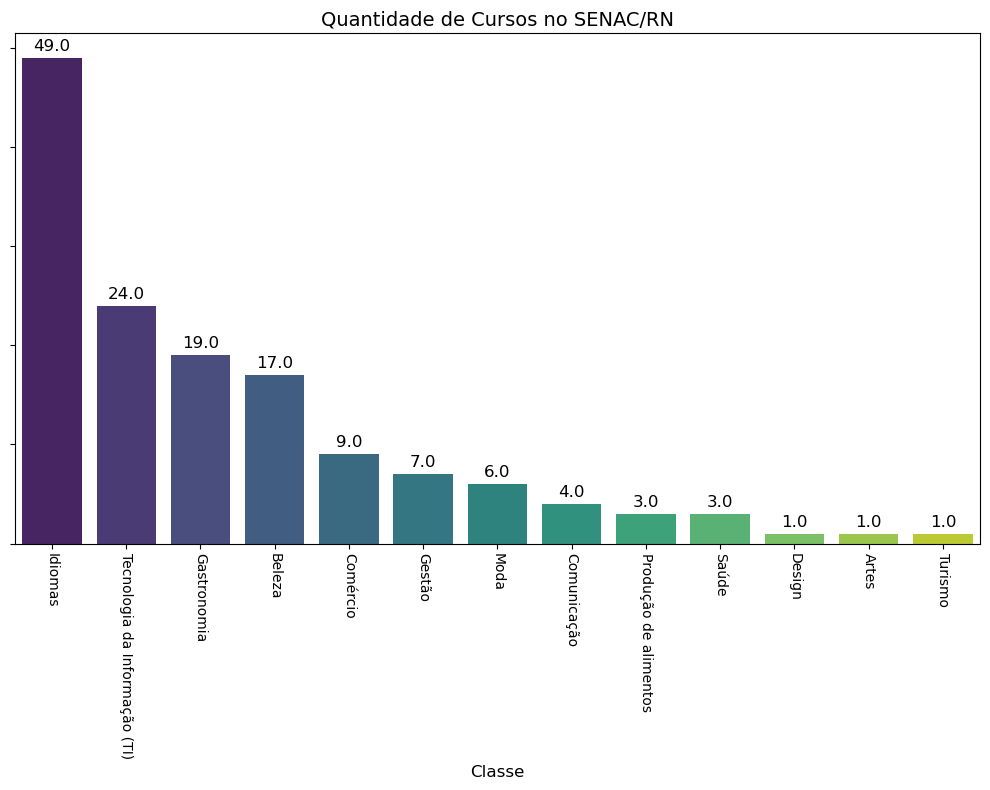

In [38]:
# Criando o gráfico de barras com Seaborn
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='Classe', y='Quantidade', data=df_cursos_viz, ax=ax, palette='viridis')

# Adicionando os valores acima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=-90, fontsize=10)

# Adicionando título e rótulos dos eixos
ax.set_title('Quantidade de Cursos no SENAC/RN', fontsize=14)
ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('')

# Ocultando os rótulos do eixo y
ax.set_yticklabels([])

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Análise dos dados CAGED

In [15]:
df_qtd_ano = df_analise.groupby('mes_ano').size().reset_index(name='Quantidade')

In [16]:
fig2 = px.line(
    df_qtd_ano, 
    x= 'mes_ano',
    y='Quantidade',
    title='Admissões em 2023',
    template='plotly_dark',
    labels={
        'mes_ano' : 'Mês/Ano',
    }
    )
fig2.add_trace(go.Scatter(
    x=df_qtd_ano['mes_ano'],
    y=df_qtd_ano['Quantidade'],
    mode='text',
    text=df_qtd_ano['Quantidade'],
    textposition='top center'
))
fig2.show()

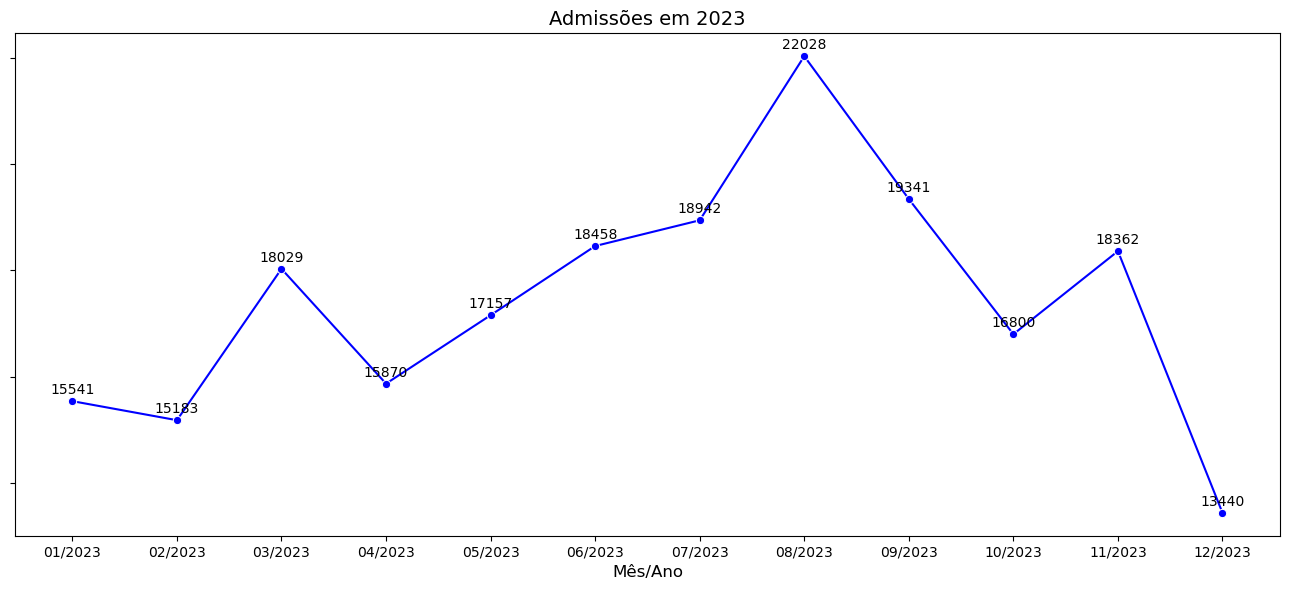

In [37]:
# Criando o gráfico de linha com Seaborn
fig, ax = plt.subplots(figsize=(13, 6))

sns.lineplot(x='mes_ano', y='Quantidade', data=df_qtd_ano, marker='o', ax=ax, color='b')

# Adicionando os valores acima de cada ponto
for i, txt in enumerate(df_qtd_ano['Quantidade']):
    ax.annotate(txt, (df_qtd_ano['mes_ano'][i], df_qtd_ano['Quantidade'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=-0, fontsize=10)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023', fontsize=14)
ax.set_xlabel('Mês/Ano', fontsize=12)
ax.set_ylabel('')

# Ocultando os rótulos do eixo y
ax.set_yticklabels([])

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()